Current `Dezero` could automatically differentiate but limited to 1st-order. Now let's expand this to more higher order

### Before start let's just have a time to look through `Variable` & `Function` class

>**Check the code at `dezero` package**

In [3]:
from dezero import Variable
from dezero import Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx

def sin(x):
    return Sin()(x)

In [4]:
x = Variable(np.array(1.0))
y = sin(x)
y

Variable(0.8414709848078965)

In [5]:
y.backward(retain_grad=True)
x.grad

Variable(0.5403023058681398)

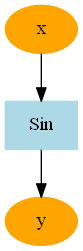

In [7]:
from dezero.utils import visualize_graph
from dezero.utils import plot_dot_graph

x.name = 'x'
y.name = 'y'

plot_dot_graph(y, verbose=False)

## Copy codes from `core_simple.py` to `core.py` and modify `core.py`

> We are going to make a new `dezero`

### Make `back propagation` as `computational graph` like in `forward`

Make the `grad` as `Variable`

```python
class Variable:

    def backward(self, retain_grad=False):
        if self.grad is None:
            # self.grad = np.ones_like(self.data)
            self.grad = Variable(np.ones_like(self.data))

```

**Inputs** at backward calculation of `Mul, Div, Pow` are changed to use the `Variable` rather `numpy`

```python
class Mul(Function):

    def backward(self, gy):
        x0, x1 = self.inputs
        return gy * x1, gy * x0

```

### `create_graph` option
> when we use 1st order differential we don't need to create graph further

`Function` makes connnection between nodes when `enable_backprop` is on.

```python
class Function:

    def __call__(self, *inputs):
    
        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])

            for output in outputs:
                output.set_creator(self)

            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

```

We changed back propagation to generate `computational graph`.<br>
To disable this because we are using 1st order we add options `create_graph`.<br>
when `create_graph` is **False** we don't create graph at back propagtion.


```python
    def backward(self, retain_grad=False, create_graph=False):
        
        ...
        
            ##### disable graph generating when only using 1st-order!
            with using_config('enable_backprop', create_graph):
           
                gxs = f.backward(*gys)
                if not isinstance(gxs, tuple):
                    gxs = (gxs,)

                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        # if we use += it will be overwrite and it could cause a problem
                        # so we use = + to copy
                        x.grad = x.grad + gx

                    if x.creator is not None:
                        add_func(x.creator)

        ...
```

### Change `__init__.py`


```python
is_simple_core = False

if is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import Function
    from dezero.core_simple import using_config
    from dezero.core_simple import no_grad
    from dezero.core_simple import as_array
    from dezero.core_simple import as_variable
    from dezero.core_simple import setup_variable
else:
    from dezero.core import Variable
    from dezero.core import Function
    from dezero.core import using_config
    from dezero.core import no_grad
    from dezero.core import as_array
    from dezero.core import as_variable
    from dezero.core import setup_variable

setup_variable()

```

## Now let's check what we got

In [1]:
from dezero import Variable
from dezero import Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0]
        gx = gy * cos(x)
        return gx
    
class Cos(Function):
    def forward(self, x):
        y = np.cos(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0]
        gx = gy * -sin(x)
        return gx
    

def sin(x):
    return Sin()(x)

def cos(x):
    return Cos()(x)

In [14]:
x = Variable(np.array(1.0))
y = sin(x)
y

Variable(0.8414709848078965)

### we can see the `x.grad` is now `Variable`

In [15]:
y.backward(retain_grad=True, create_graph=True)
x.grad

Variable(0.5403023058681398)

### `back propagation` is now connected on `computational graph`

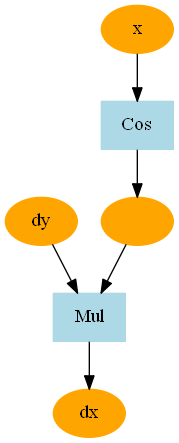

In [16]:
from dezero.utils import visualize_graph
from dezero.utils import plot_dot_graph

x.name = 'x'
y.name = 'y'
x.grad.name = 'dx'
y.grad.name = 'dy'

plot_dot_graph(x.grad, verbose=False)

## 2nd order without `cleargard`

In this case we will see that `1st order` and `2nd order` gradient is accumulated. This should not happen!

### $f(x) = sin(x)$
### $f'(x) = cos(x)$
### $f''(x) = -sin(x)$

### `x.grad` should be $f''(1)$ but become $f'(1) + f''(1)$

In [5]:
dx = x.grad
dx.backward(retain_grad=True, create_graph=True)
x.grad

Variable(-0.30116867893975674)

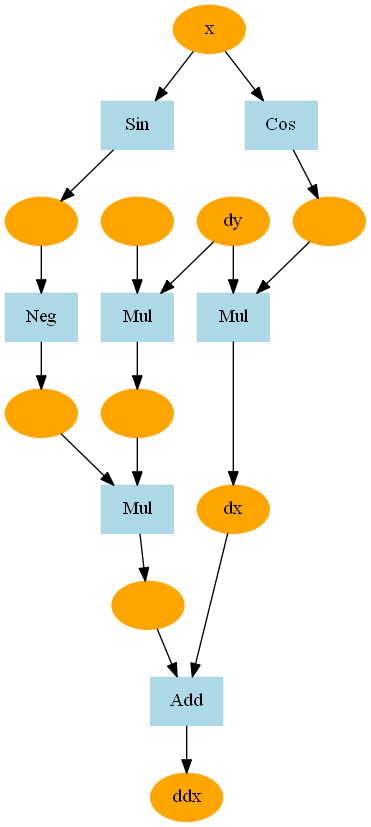

In [6]:
from dezero.utils import visualize_graph
from dezero.utils import plot_dot_graph

x.grad.name = 'ddx'

plot_dot_graph(x.grad, verbose=False)

## 2nd order with `cleargrad`

In [18]:
dx = x.grad

# prevent gradient added
x.cleargrad()

dx.backward(retain_grad=True, create_graph=True)
x.grad

Variable(-0.8414709848078965)

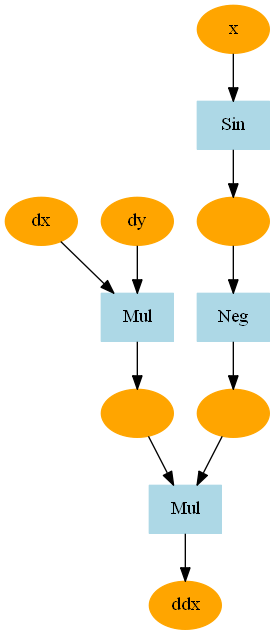

In [19]:
from dezero.utils import visualize_graph
from dezero.utils import plot_dot_graph

dx.grad.name = 'dx'
x.grad.name = 'ddx'

plot_dot_graph(x.grad, verbose=False)